In [1]:
import sys, time, argparse, re, gensim, math
import pandas as pd
from tqdm import tqdm
import pickle as pkl
import numpy as np
import faulthandler
import logging
from os.path import exists
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import plotly.graph_objects as go

In [2]:
def read_file(input_path):
    logging.info('Opened: ' + input_path)
    with open(input_path, "rb") as f:
        input_obj = pkl.load(f)
        return input_obj

In [50]:
df_1700 = read_file('../data/1700/1700_all_top_descriptors_500.pickle').reset_index(drop=True)
df_1800 = read_file('../data/1800/1800_all_top_descriptors_500.pickle').reset_index(drop=True)
df_1900 = read_file('../data/1900/1900_all_top_descriptors_500.pickle').reset_index(drop=True)

In [51]:
df_1700['literary_period'] = '1700'
df_1800['literary_period'] = '1800'
df_1900['literary_period'] = '1900'

In [52]:
combined_periods = pd.concat([df_1700, df_1800])
combined_periods = pd.concat([combined_periods, df_1900])

In [53]:
sight_df = combined_periods.loc[combined_periods['modality'] == 'sight']
hear_df = combined_periods.loc[combined_periods['modality'] == 'hear']
touch_df = combined_periods.loc[combined_periods['modality'] == 'touch']
taste_df = combined_periods.loc[combined_periods['modality'] == 'taste']
smell_df = combined_periods.loc[combined_periods['modality'] == 'smell']

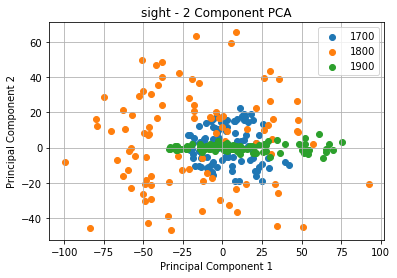

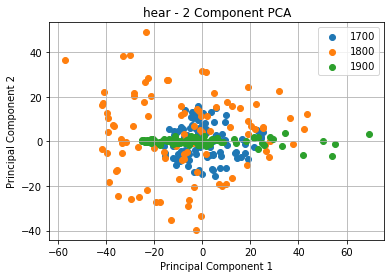

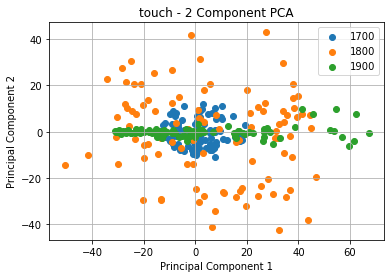

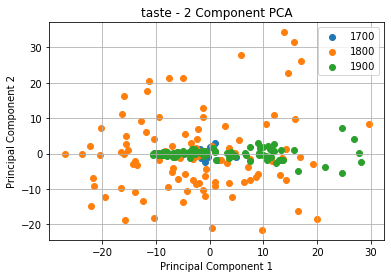

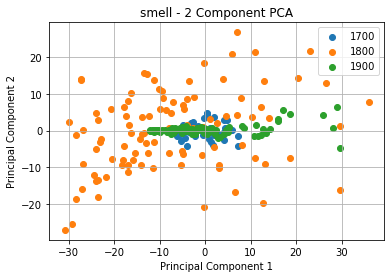

In [54]:
modality_dict = {'sight': sight_df, 'hear': hear_df, 'touch': touch_df, 'taste': taste_df, 'smell': smell_df}
k = 2

for modality, df in modality_dict.items():
    fig = px.scatter(
                df,
                color=df["literary_period"],
                color_discrete_map={'1700': '#1f77b4', '1800': '#2ca02c', '1900': '#d62728'},
                x=df['Principal Component 1'],
                y=df['Principal Component 2'],
                hover_data=df.columns[:-1 * k],
                custom_data=df.columns[:-1 * k],
                title= modality + " - " + str(k) + " Component PCA")
    fig.update_traces(marker=dict(size=12,))
    fig.write_html('../visuals/' + modality + '_pca_plot.html')
    fig.show()

    fig, ax = plt.subplots()
    for i,d in df.groupby('literary_period'):
        ax.scatter(d['Principal Component 1'], d['Principal Component 2'], label=i)
    plt.title(modality + " - " + str(k) + " Component PCA")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig('../visuals/' + modality + '_pca_plot.pdf')

### Average Pairwise Distance between Sense Pairs AND  Sensory Descriptors within a 30-radius Area

In [47]:
SENSES = ['sight', 'hear', 'touch', 'taste', 'smell']
radius = 30
literary_periods = ['1700', '1800', '1900', 'full_corpus']

def format_key(pair):
    return ", ".join(sorted(pair))


def avg(value):
    ret = 0 if value[1] == 0 else value[0]/value[1]
    return ret

for period in literary_periods:

    senses_and_freqs = {format_key((SENSES[i],SENSES[j])):0 for i in range(len(SENSES)) for j in range(i, len(SENSES))}
    senses_and_avgs = {format_key((SENSES[i],SENSES[j])):[0,0] for i in range(len(SENSES)) for j in range(i, len(SENSES))}

    all_top_descriptors = read_file('../data/' + period + '/' + period + '_all_top_descriptors_500.pickle')
    
    points = []
    points_with_sense = []
    for index, row in all_top_descriptors.iterrows():
        points.append([row['Principal Component 1'], row['Principal Component 2']])
        points_with_sense.append([[row['Principal Component 1'], row['Principal Component 2']], row['modality']])
        
    euclidean_dists = euclidean_distances(points, points)
    
    total = 0
    same_sense = 0
    for i, row in enumerate(euclidean_dists):
        for j, distance in enumerate(row):
            if i == j: continue
            sense_i = points_with_sense[i][1]
            sense_j = points_with_sense[j][1]
            pair = format_key([sense_i, sense_j])
            senses_and_avgs[pair][0] += distance
            senses_and_avgs[pair][1] += 1

            if distance > radius:
                continue
            senses_and_freqs[pair] += 1
            if sense_i == sense_j:
                same_sense += 1
            total += 1
    senses_and_avgs = {pair:avg(value) for pair, value in senses_and_avgs.items()}
    
    colors = ['lightslategray',] * len(senses_and_freqs)
    same_indices = [i for i, pair in enumerate(senses_and_freqs) if pair.split(", ")[0] == pair.split(", ")[1]]
    for i in same_indices:
        colors[i] = "crimson"
    layout = go.Layout(
        title = period + " - Total Number of Sense Pairs",
        xaxis = dict(title="Sense Pair"),
        yaxis = dict(title="Pairs within radius of " + str(radius))
    )
    fig = go.Figure(layout=layout,
                    data=[go.Bar(x = list(senses_and_freqs.keys()),
                            y = list(senses_and_freqs.values()),
                    marker_color=colors)])

    fig.show()
    fig.write_html('../visuals/' + period + '/' + period + '_total_sense_pairs_500.html')
    
    layout = go.Layout(
            title = period + " - Average Distance Between Sense Pairs",
            xaxis = dict(title="Sense Pair"),
            yaxis = dict(title="Average distance")
        )
    colors = ['lightslategray',] * len(senses_and_avgs)
    same_indices = [i for i, pair in enumerate(senses_and_avgs) if pair.split(", ")[0] == pair.split(", ")[1]]
    for i in same_indices:
        colors[i] = "mediumvioletred"
    fig = go.Figure(layout=layout,
                    data=[go.Bar(x = list(senses_and_avgs.keys()),
                            y = list(senses_and_avgs.values()),
                    marker_color=colors)])
    fig.show()
    fig.write_html('../visuals/' + period + '/' + period + '_average_distance_between_sense_pairs_500.html')


### Ranked Descriptors

In [81]:
for period in literary_periods: 
    all_top_descriptors = read_file('../data/' + period + '/' + period + '_all_top_descriptors_500.pickle')
    filtered_descriptors = read_file('../data/' + period + '/filtered_descriptors.pickle')
    
    all_top_descriptors = all_top_descriptors.reset_index(drop = True)
    all_top_descriptors['descriptor'] = all_top_descriptors['word'].str[0]
    all_top_descriptors['POS'] = all_top_descriptors['word'].str[1]
    senses = [sense for sense in set(all_top_descriptors["modality"].values)]
    ranked = pd.DataFrame(columns=["descriptor", "POS"] + senses + ['total'])
    ranked.loc[:,'descriptor'] = all_top_descriptors['descriptor']
    ranked.loc[:,'POS'] = all_top_descriptors["POS"]
    ranked = ranked.drop_duplicates().fillna(0).reset_index(drop=True)
    for index, row in all_top_descriptors.iterrows():
        # get row of matching descriptor
        ranked_row = ranked.loc[(ranked['descriptor'] == row['descriptor']) & (ranked['POS'] == row['POS'])]
        ranked_idx = ranked_row.index
        ranked.at[ranked_idx[0], row["sense"]] = filtered_descriptors[row['modality']][row['word']]

    # Calculate the total frequency for each descriptor
    for sense in senses:
        ranked["total"] += ranked[sense]

    ranked = ranked.sort_values("total", ascending=False)

    # Remove all the descriptors that show no overlap of senses
    one_sense_only = ranked[(ranked == 0).sum(1) >= 4].index
    ranked = ranked.drop(one_sense_only)
    words = ranked["descriptor"].values
    n = min(20, len(words))
    data = []
    for label in SENSES:
        try:
            data.append(go.Bar(name=label, x=words[:n], y=ranked[label][:n].values/num_windows[label]))
        except KeyError:
            continue

    layout = go.Layout(
        title = period + "- Descriptor Sense Overlap",
        xaxis = dict(title="Top " + str(n) + " Descriptors"),
        yaxis = dict(title="Frequency")
    )
    fig = go.Figure(layout=layout, data=data)
    fig.update_layout(barmode='stack')
    fig.show()

#     label_path = get_model_path(args, load_model=args.load_model, file_type="label_tsv_ranked", combined=args.combined)
    # ranked.to_csv(label_path, index=True, header=True, sep="\t")

#     overlap_path = get_model_path(args, load_model=args.load_model, file_type="overlap_plot", combined=args.combined)
#     fig.write_html(overlap_path)

KeyError: 'frequency'